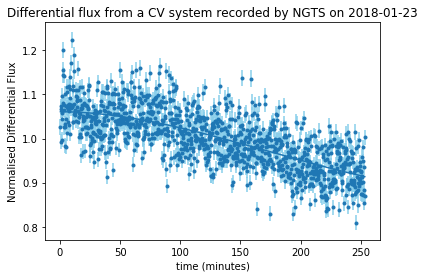

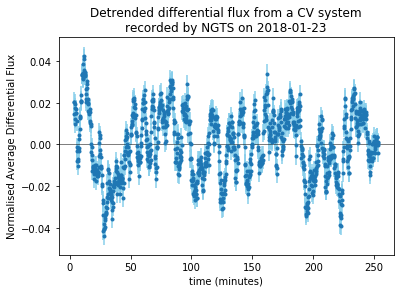

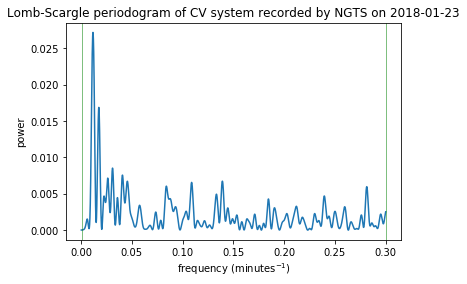

Peak maximum: 0.02717638873963633
Tallest peak at frequency: 0.011750830166033205 per minute,
in frequency range: 0.001 to 0.3 per minute.
Tallest peak at period: 5106.022225853899 s.
Probability this peak is due to random noise: 0.0


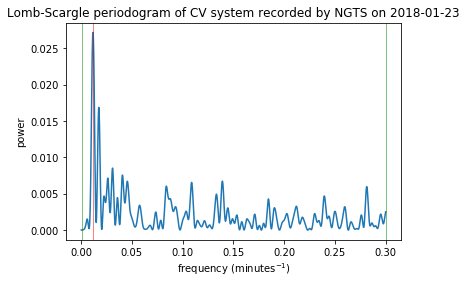

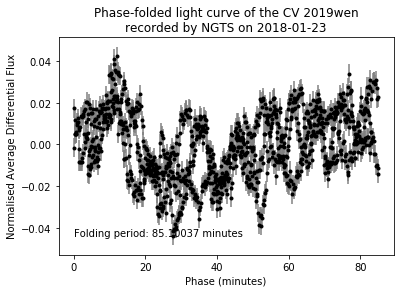

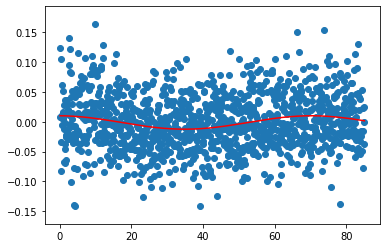

In [6]:
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from scipy.optimize import curve_fit

def rolling_errors(data, window_size):
    length = len(data)
    propagated_errors = []
    
    for i in range(length):
        window = data[max(i-window_size, 0) : i]
        
        if len(window) < window_size:
            propagated_errors.append(np.nan)
            
        else:
            temp = np.array(window)*np.array(window)
            temp = np.sqrt(np.sum(temp)) / window_size
            propagated_errors.append(temp)
    
    return(propagated_errors)


dates = ['2018-01-16', '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20',
         '2018-01-21', '2018-01-22', '2018-01-23', '2018-01-24', '2018-01-25',
         '2018-01-26', '2018-01-27', '2018-01-28', '2018-01-29']
#date = dates[5]
date = '2018-01-23'

win = 15

# frequency range to investigate peaks
# -----------------------------------
fmin = 0.001
fmax = 0.3
# pmin = 5000
# pmax = 10000
# fmin = 60/pmax
# fmax = 60/pmin
#pow_ylim = 0.1

frequencies = np.linspace(3E-4, fmax, 5000)
exclude = [8]
FA_level = 0.05
P_fold = 5185

# =============================================================================
# switch for choosing what to plot
# =============================================================================
switch = 0

if switch:  # use to check comparison stars and the initial periodogram
    test_comparisons = 0
    plot_window_function_frequency = 0
    plot_window_function_period = 0
    plot_light_curve_with_best_fit = 1
    plot_detrended_light_curve = 0
    plot_frequency_power_sprectrum = 0
    plot_period_power_sprectrum = 0
    calculate_FA_level = 1
    calculate_FAP = 0
    plot_period_power_sprectrum_with_peak = 0
    plot_frequency_power_sprectrum_with_peak = 1
    plot_best_fit_sinusoid = 0
    plot_phase_folded_light_curve = 1
    plot_window_function_and_periodogram = 0
else:  # use analyse the FAP value of peaks
    test_comparisons = 0
    plot_window_function_frequency = 0
    plot_window_function_period = 0
    plot_light_curve_with_best_fit = 1
    plot_detrended_light_curve = 1
    plot_frequency_power_sprectrum = 1
    plot_period_power_sprectrum = 0
    calculate_FA_level = 0
    calculate_FAP = 1
    plot_period_power_sprectrum_with_peak = 0
    plot_frequency_power_sprectrum_with_peak = 1
    plot_best_fit_sinusoid = 0
    plot_phase_folded_light_curve = 1
    plot_window_function_and_periodogram = 0

# =============================================================================

csvfile = f"/Users/XKARAN3135X/Project Term 2/CSV Files/2018iz_photometry_data_centroidFalse_{date}.csv" 
#csvfile = "20th.csv"
num_comparisons = 5 # number of comparison stars in csv file

# get data from csv
data = pd.read_csv(csvfile)

star_flux = data["Flux"]
star_flux_err = data["Flux_err"]

times = data['Time']

# rearrange data into chronological order (necessary for plotting)
star_flux = pd.Series([x for _, x in sorted(zip(times, star_flux), key=lambda pair: pair[0])])
star_flux_err = pd.Series([x for _, x in sorted(zip(times, star_flux_err), key=lambda pair: pair[0])])
times = pd.Series(sorted(times))

conversion_factor = 24 * 60  # convert to minutes
dt = (times - times[0]) * conversion_factor
length = len(dt)

diff_fluxes = [0] * length
diff_errors = [0] * length
for i in range(length):
    diff_fluxes[i] = []
    diff_errors[i] = []
fluxes = pd.Series(np.zeros(length))
errors = pd.Series(np.zeros(length))
# upper = pd.Series(np.zeros(length))
# lower = pd.Series(np.zeros(length))
window = np.ones(length)

# =============================================================================
# find the fourier transform of the window function
# =============================================================================
winpower = LombScargle(dt[3:], window[3:]).power(frequencies)

if plot_window_function_frequency:
    #frequencies, winpower = LombScargle(dt[1:], window[1:]).autopower(maximum_frequency=4.75)

    plt.plot(frequencies, winpower)
    plt.xlabel("frequency (minutes$^{-1}$)")
    plt.ylabel("log ( power )")
    #plt.ylim((0, 20))
    plt.yscale('log')
    plt.title(f"LombScargle periodogram of the window function on {date}")
    plt.show()

if plot_window_function_period:
    periods = 60/frequencies
    
    plt.plot(periods, winpower)
    plt.xlabel("period (seconds)")
    plt.xscale('log')
    # plt.ylim((0, 0.1))
    # plt.ylabel("power")
    plt.yscale('log')
    plt.ylabel("log ( power )")
    plt.title(f"LombScargle periodogram of the window function on {date}")
    plt.show()
    
# =============================================================================


for i in range(num_comparisons):
    index_str1 = f"compare{i+1}_flux"
    temp = data[index_str1]
    spread = np.nanquantile(temp, 0.75) - np.nanquantile(temp, 0.25)
    average = np.nanquantile(temp, 0.5)
    temp[np.abs(temp - average) > 2*spread] = np.nan
    
    if test_comparisons:
        plt.scatter(dt, temp.rolling(win).mean())
        plt.title('Comparison star: ' + str(i))
        plt.show()
    
    if i not in exclude:
        # calculate the differential flux and propagate the error
        temp = star_flux/data[index_str1]
        
        index_str2 = f"compare{i+1}_error"
        temperr = np.abs(temp) * np.sqrt( (star_flux_err/star_flux)**2 +
                                  (data[index_str2]/data[index_str1])**2 )
    
        
        # filter out anomalous values
        spread = np.nanquantile(temp, 0.75) - np.nanquantile(temp, 0.25)
        average = np.nanquantile(temp, 0.5)
        temp[np.abs(temp - average) > 3*spread] = np.nan
        temperr[np.abs(temperr) > 0.1] = np.nan
        
        # normalise the differential flux
        average = np.mean(temp)
        temp = temp / average
        temperr = temperr / average
        
        # hold the differential flux and error calculated for each comparison
        # star to find the weighted average later
        for j in range(length):
            diff_fluxes[j].append(temp[j])
            diff_errors[j].append(temperr[j])


diff_fluxes = np.array(diff_fluxes)
diff_errors = np.array(diff_errors)
for i in range(length):
    # calculates the average flux and propagates the error
    fluxes[i] = np.nanmean(diff_fluxes[i])
    errors[i] = np.sqrt(np.nansum(diff_errors[i]*diff_errors[i])) / num_comparisons
    
    # remove erroneous NaNs (which LombScargle can't handle)
    if math.isnan(fluxes[i]) or math.isnan(errors[i]):
        fluxes.pop(i)
        errors.pop(i)
        dt.pop(i)
# discard zero value at the start of each array
dt = dt[1:]
fluxes = fluxes[1:]
errors = errors[1:]


def line(x, m, c):
    return m*x + c

def poly(x, a, b, c, d):
    return ((a*x + b)*x + c)*x + d

# perform best fit to a cubic in order to detrend
params, cov = curve_fit(poly, dt, fluxes)
polyfit = poly(dt, params[0], params[1], params[2], params[3])
# params, cov = curve_fit(line, dt, fluxes, (8E-5, 1))
# polyfit = line(dt, params[0], params[1])

# =============================================================================
# plot the light curve and best fit line
# =============================================================================
if plot_light_curve_with_best_fit:
    if length < 24:
        win = 1
    plt.errorbar(dt, fluxes, yerr=errors, fmt='.', ecolor='skyblue')
    plt.plot(dt, polyfit, zorder=10000)
    plt.xlabel("time (minutes)")
    plt.ylabel("Normalised Differential Flux")
    plt.title(f"Differential flux from a CV system recorded by NGTS on {date}")
    plt.show()

fluxes = fluxes - polyfit

# =============================================================================
# plot the detrended light curve
# =============================================================================
av_fluxes = fluxes.rolling(win).mean()
av_errors = rolling_errors(errors, win)

if plot_detrended_light_curve:
    if length < 24:
        win = 1
    plt.axhline(y=0, color='k', lw=0.5)
    #plt.scatter(dt[win:], av_fluxes[win:], s=2)
    plt.errorbar(dt, av_fluxes, yerr=av_errors, fmt='.', ecolor='skyblue')
    plt.xlabel("time (minutes)")
    plt.ylabel("Normalised Average Differential Flux")
    plt.title(f"Detrended differential flux from a CV system\nrecorded by NGTS on {date}")
    plt.show()


# calculate Lomb-Scargle periodogram
periodogram = LombScargle(dt, fluxes, errors)
power = periodogram.power(frequencies)
#frequencies, power = periodogram.autopower(maximum_frequency=4.5)
# max frequency is 4.5 to avoid peaks due to the window function

if calculate_FA_level:
    FA_power = periodogram.false_alarm_level(FA_level,
                                             method='bootstrap',
                                             minimum_frequency=fmin,
                                             maximum_frequency=fmax,
                                             method_kwds={'n_bootstraps':3000})


# =============================================================================
# plot the power-frequency sprectrum
# =============================================================================
if plot_frequency_power_sprectrum:
    plt.plot(frequencies, power)
    #plt.ylim((0, pow_ylim))
    if calculate_FA_level:
        plt.axhline(y=FA_power, color='m', lw=0.5)
    if calculate_FAP:
        plt.axvline(x=fmin, color='g', lw=0.5)
        plt.axvline(x=fmax, color='g', lw=0.5)
    plt.xlabel("frequency (minutes$^{-1}$)")
    plt.ylabel("power")
    plt.title(f"Lomb-Scargle periodogram of CV system recorded by NGTS on {date}")
    plt.show()

periods = 60/frequencies


# fig, axes = plt.subplots(1, 2)
# axes[0].set_box_aspect(1)
# axes[1].set_box_aspect(0.9)
# axes[0].errorbar(dt, fluxes+polyfit, yerr=errors, fmt='.')
# axes[0].plot(dt, polyfit, zorder=10000)
# axes[0].set_xlabel("time (minutes)")
# axes[0].set_ylabel("Normalised Average\nDifferential Flux")
# axes[0].set_title(f"Average flux\nfrom CV 2019wen\nrecorded by NGTS on {date}")
# axes[1].plot(frequencies, power)
# axes[1].set_xlabel("frequency (minutes$^{-1}$)")
# axes[1].set_ylabel("power")
# axes[1].set_title(f"Lomb-Scargle periodogram\nof CV 2019wen\nrecorded by NGTS on {date}")
# fig.tight_layout()
# plt.show()


# =============================================================================
# plot the power-period spectrum
# =============================================================================
if plot_period_power_sprectrum:
    plt.plot(periods, power)
    if calculate_FA_level:
        plt.axhline(y=FA_power, color='m', lw=0.5)
    if plot_period_power_sprectrum_with_peak:
        pmin = 60/fmax
        pmax = 60/fmin
        if calculate_FAP:
            plt.axvline(x=pmin, color='g', lw=0.5)
            plt.axvline(x=pmax, color='g', lw=0.5)
    plt.xlabel("period (seconds)")
    plt.xscale('log')
    plt.yscale('log')
    #plt.ylim((0, 0.0225))
    plt.ylabel("power")
    plt.title(f"Lomb-Scargle periodogram of CV system recorded by NGTS on {date}")


# =============================================================================
# find significant peaks
# =============================================================================

minidx = np.where(frequencies==min(frequencies, key=lambda x:abs(x-fmin)))[0][0]
maxidx = np.where(frequencies==min(frequencies, key=lambda x:abs(x-fmax)))[0][0]

peak_maximum = power[minidx:maxidx].max()
print('Peak maximum: ' + str(peak_maximum))

peak_idx = np.where(power[minidx:maxidx]==peak_maximum)[0][0] + minidx
peak_centre = frequencies[peak_idx]
print(f"Tallest peak at frequency: {peak_centre} per minute,")
print(f"in frequency range: {fmin} to {fmax} per minute.")
peak_period = periods[peak_idx]
print(f"Tallest peak at period: {peak_period} s.")
if calculate_FAP:
    peak_error = periodogram.false_alarm_probability(peak_maximum, method='bootstrap',
                                                     minimum_frequency=fmin,
                                                     maximum_frequency=fmax,
                                                     method_kwds={'n_bootstraps':3000})
    print(f"Probability this peak is due to random noise: {peak_error}")

# show position of the peak on the period spectrum
if plot_period_power_sprectrum_with_peak:
    plt.axvline(x=peak_period, color='r', lw=0.5)  # plot  line at the identified peak
    
if plot_period_power_sprectrum:
    plt.show()


# =============================================================================
# plot the power-frequency spectrum with the frequency range and peak inspected
# =============================================================================
if plot_frequency_power_sprectrum_with_peak:
    plt.plot(frequencies, power)
    #plt.ylim((0, pow_ylim))
    if calculate_FAP:
        plt.axvline(x=fmin, color='g', lw=0.5)
        plt.axvline(x=fmax, color='g', lw=0.5)
    if calculate_FA_level:
        plt.axhline(y=FA_power, color='m', lw=0.5)
    plt.axvline(x=peak_centre, color='r', lw=0.5)
    plt.xlabel("frequency (minutes$^{-1}$)")
    plt.ylabel("power")
    plt.title(f"Lomb-Scargle periodogram of CV system recorded by NGTS on {date}")
    plt.show()


# =============================================================================
# plot the detrended light curve and best fit sinusoid
# =============================================================================
sinefit = periodogram.model(dt, peak_centre)

if plot_best_fit_sinusoid:
    if length < 24:
        win = 1
    plt.errorbar(dt, av_fluxes, yerr=av_errors, fmt='.', ecolor='skyblue')
    plt.plot(dt, sinefit, color='r', lw=2, zorder=10000)
    plt.xlabel("time (minutes)")
    plt.ylabel("Normalised Average Differential Flux")
    plt.title(f"Differential light curve of 2019wen on {date}\n with a sinusoid fitted at its periodogram's strongest frequency")
    plt.show()


# =============================================================================
# plot the phase-folded light curve
# =============================================================================
#if plot_phase_folded_light_curve:
P_fold = peak_period
P_fold = P_fold/60  # convert P_fold to minutes
phase = dt % P_fold
text = 'Folding period: ' + str(round(P_fold, 5)) + ' minutes'
plt.errorbar(phase, av_fluxes, yerr=av_errors, fmt='.', color='k', ecolor='gray')
plt.xlabel("Phase (minutes)")
plt.ylabel("Normalised Average Differential Flux")
plt.title(f"Phase-folded light curve of the CV 2019wen\nrecorded by NGTS on {date}")
anny = np.nanquantile(av_fluxes, 0)
plt.annotate(text, (0, anny))
plt.show()

phluxes = pd.Series([x for _, x in sorted(zip(phase, fluxes), key=lambda pair: pair[0])])
pherrors = pd.Series([x for _, x in sorted(zip(phase, errors), key=lambda pair: pair[0])])
phase = pd.Series(sorted(phase))

def wave(x, A, B, n, L, c):
    pi = np.pi
    return A*np.sin(n*pi*x/L) + B*np.cos(n*pi*x/L) + c

try:
    guesses = [np.quantile(phluxes, 0.25), phluxes[0], 2, P_fold, 0]
    params, cov = curve_fit(wave, phase, phluxes, p0=guesses)
    wavefit = wave(phase, params[0], params[1], params[2], params[3], params[4])
except RuntimeError:
    params, cov = curve_fit(poly, phase, phluxes)
    wavefit = poly(phase, params[0], params[1], params[2], params[3])


plt.scatter(phase, phluxes)
plt.plot(phase, wavefit, color='r', zorder=10000)
plt.show()

# =============================================================================
# plot the envelopes of the light curve defined by the errors
# =============================================================================
# #  plot the upper and lower envelopes, determined by the error
# upper = fluxes + errors
# lower = fluxes - errors
# upper_av = upper.rolling(win).mean()
# lower_av = lower.rolling(win).mean()
# plt.plot(dt[win:], upper_av[win:], linewidth=0.5)
# plt.plot(dt[win:], lower_av[win:], linewidth=0.5)
# plt.show()


# =============================================================================
# plot the window function power spectrum and data power spectrum together
# =============================================================================
if plot_window_function_and_periodogram:
    periods = 60/frequencies
    plt.plot(periods, winpower, label='window function')
    plt.plot(periods, power, label='periodogram')
    plt.xlabel("period (seconds)")
    plt.xscale('log')
    plt.ylim((1E-4, 100))
    #plt.ylabel("power")
    if calculate_FA_level:
        plt.axhline(y=FA_power, color='m', lw=0.5)
    plt.yscale('log')
    plt.ylabel("log ( power )")
    #plt.title(f"Lomb-Scargle periodogram and window function\nof 2019wen recorded by NGTS on {date}")
    plt.legend()
    plt.show()
    
    # periods = 60/frequencies
    # plt.plot(periods, power, label='periodogram')
    # plt.plot(periods, winpower, label='window function')
    # plt.xlabel("period (seconds)")
    # plt.xscale('log')
    # #plt.ylim((0, 0.1))
    # #plt.ylabel("power")
    # if calculate_FA_level:
    #     plt.axhline(y=FA_power, color='m', lw=0.5)
    # plt.yscale('log')
    # plt.ylabel("log ( power )")
    # plt.title(f"Lomb-Scargle periodogram of CV system recorded by NGTS on {date}")
    # plt.legend()
    # plt.show()